# 데이터 소개

캐글 [DataCo SMART SUPPLY CHAIN FOR BIG DATA ANALYSIS](https://www.kaggle.com/datasets/shashwatwork/dataco-smart-supply-chain-for-big-data-analysis?utm_source=chatgpt.com)

주문(Order) ~ 출하(Shipment) ~ 배송(Delivery)까지 전 과정이 포함된 공급망 데이터

#0.기본세팅

In [1]:
#필요 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import PercentFormatter, FuncFormatter

In [41]:
from prophet import Prophet

In [2]:
# 코랩 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 파일 불러오기

# 실제 분석 대상 데이터 (주문~출하~배송)
df1 = pd.read_csv(
    "/content/drive/MyDrive/분석/공급망_최적화/DataCoSupplyChainDataset.csv",encoding="latin1")

# 데이터 설명(사전)
df2 = pd.read_csv(
    "/content/drive/MyDrive/분석/공급망_최적화/DescriptionDataCoSupplyChain.csv",encoding="latin1")

# 토큰화 액세스 로그
df3 = pd.read_csv(
    "/content/drive/MyDrive/분석/공급망_최적화/tokenized_access_logs.csv",encoding="latin1")

In [4]:
#나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (30.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126435 files and direc

In [5]:
# 그래프 한글깨짐 현상
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

fm.fontManager.addfont(font_path)
prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

#그래프 설정
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 150)
plt.rcParams["figure.figsize"] = (12, 4)

In [6]:
supply_chain_data = df1.copy()
supply_chain_desc = df2.copy()
access_logs = df3.copy()

In [ ]:
supply_chain_data.head(3)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class


#1.전처리

In [7]:
print(supply_chain_data.columns.tolist())

['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Delivery Status', 'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City', 'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id', 'Customer Lname', 'Customer Password', 'Customer Segment', 'Customer State', 'Customer Street', 'Customer Zipcode', 'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market', 'Order City', 'Order Country', 'Order Customer Id', 'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status', 'Order Zipcode', 'Product Card Id', 'Product Category Id', 'Product Description', 'Product Image', 'Product Name', 'Product Price', 'Product Status', 'shipping date (DateOrde

In [8]:
# 필요한 컬럼만 직관적인 이름으로 바꾸기

column_map = {
    "order date (DateOrders)": "order_date",          # 주문일자
    "shipping date (DateOrders)": "shipping_date",    # 출하일자
    "Days for shipping (real)": "lt_real_days",       # 실제 리드타임(주문→출하) // ((실제 배송 일수))
    "Days for shipment (scheduled)": "lt_sched_days", # 계획 리드타임(주문→출하) // (예정 배송 일수)
    "Late_delivery_risk": "late_risk",                # 지연 위험( 0 =괜찮음 / 1= 늦음 위험)
    "Delivery Status": "delivery_status",             # 배송 상태 텍스트
    "Shipping Mode": "shipping_mode",                 # 운송/배송 모드
    "Order Id": "order_id",                           # 주문 ID
    "Order Item Id": "order_item_id",                 # 라인아이템 ID (상품별 세부 ID)
    "Order Item Quantity": "order_qty",               # 주문 수량
    "Order Item Product Price": "unit_price",         # 단가
    "Order Region": "order_region",                   # 지역
    "Order Country": "order_country",                 # 국가
    "Category Name": "category_name"                  # 카테고리 이름
}
core_table = supply_chain_data.rename(columns=column_map)

In [9]:
# 필요한 컬럼만 추림 (위에 이름 바꾼 컬럼 데이터만)
required_cols = list(column_map.values())
core_table = core_table[required_cols]

print("core_table:", core_table.shape)
core_table.head(3)

core_table: (180519, 14)


,order_date,shipping_date,lt_real_days,lt_sched_days,late_risk,delivery_status,shipping_mode,order_id,order_item_id,order_qty,unit_price,order_region,order_country,category_name
0,1/31/2018 22:56,2/3/2018 22:56,3,4,0,Advance shipping,Standard Class,77202,180517,1,327.75,Southeast Asia,Indonesia,Sporting Goods
1,1/13/2018 12:27,1/18/2018 12:27,5,4,1,Late delivery,Standard Class,75939,179254,1,327.75,South Asia,India,Sporting Goods
2,1/13/2018 12:06,1/17/2018 12:06,4,4,0,Shipping on time,Standard Class,75938,179253,1,327.75,South Asia,India,Sporting Goods


In [10]:
# 날짜형으로 변환: 문자열 → datetime
core_table["order_date"]    = pd.to_datetime(core_table["order_date"], errors="coerce")
core_table["shipping_date"] = pd.to_datetime(core_table["shipping_date"], errors="coerce")

# 리드타임 숫자화 및 차이 계산
core_table["lt_real_days"]  = pd.to_numeric(core_table["lt_real_days"], errors="coerce")
core_table["lt_sched_days"] = pd.to_numeric(core_table["lt_sched_days"], errors="coerce")
core_table["lt_gap_days"]   = core_table["lt_real_days"] - core_table["lt_sched_days"]  # +이면 지연 경향

# 지연/OTD 플래그 생성
# - 아주 단순한 기준: 실제 리드타임이 계획보다 크면 지연(late_flag=1), 아니면 제시간(OTD).
core_table["late_flag"] = (core_table["lt_gap_days"] > 0).astype(int)
core_table["otd_flag"]  = (core_table["late_flag"] == 0).astype(int)

<h4>1. 리드타임 </h4>
- lt_gap_days는 “지연이 얼마나 생겼는지' (실제 걸린 일수 - 계획된 일수)

  (0 → 정확히 계획대로 배송됨  /  양수(+)= 지연 발생  /  음수(-)= 계획보다 빨리 배송됨)

<h4>2. 플래그</h4>
- 플래그 {True/False (또는 1/0)로 표시하는 단순한 구분 변수}

- 지연이면 late_flag = 1 / 지연 아니면 late_flag = 0

- 제시간이면 otd_flag = 1 / 늦었으면 otd_flag = 0

In [11]:
core_table.head(3)

,order_date,shipping_date,lt_real_days,lt_sched_days,late_risk,delivery_status,shipping_mode,order_id,order_item_id,order_qty,unit_price,order_region,order_country,category_name,lt_gap_days,late_flag,otd_flag
0,2018-01-31 22:56:00,2018-02-03 22:56:00,3,4,0,Advance shipping,Standard Class,77202,180517,1,327.75,Southeast Asia,Indonesia,Sporting Goods,-1,0,1
1,2018-01-13 12:27:00,2018-01-18 12:27:00,5,4,1,Late delivery,Standard Class,75939,179254,1,327.75,South Asia,India,Sporting Goods,1,1,0
2,2018-01-13 12:06:00,2018-01-17 12:06:00,4,4,0,Shipping on time,Standard Class,75938,179253,1,327.75,South Asia,India,Sporting Goods,0,0,1


#2.진단분석

### 2-1) 데이터 품질/핵심 요약

In [12]:
# 품질/핵심 KPI 요약
def p95(series):
    x = pd.to_numeric(series, errors="coerce").dropna()
    return np.percentile(x, 95) if len(x) else np.nan

diagnostic_summary = {
    "rows": len(core_table),
    "order_date_null_%": core_table["order_date"].isna().mean()*100,
    "shipping_date_null_%": core_table["shipping_date"].isna().mean()*100,
    "lt_real_null_%": core_table["lt_real_days"].isna().mean()*100,
    "lt_sched_null_%": core_table["lt_sched_days"].isna().mean()*100,
    "late_rate_%": core_table["late_flag"].mean()*100,
    "otd_rate_%": core_table["otd_flag"].mean()*100,
    "avg_lt_real": core_table["lt_real_days"].mean(),
    "p95_lt_real": p95(core_table["lt_real_days"])
}

pd.Series(diagnostic_summary).round(3)

,0
rows,180519.000
order_date_null_%,0.000
shipping_date_null_%,0.000
lt_real_null_%,0.000
lt_sched_null_%,0.000
late_rate_%,57.279
otd_rate_%,42.721
avg_lt_real,3.498
p95_lt_real,6.000


< 코드 >
1. 결측치(null) 비율 확인
2. 지연율 / OTD율 계산

    ▶전체 주문 중 지연된 비율 (late_rate_%) / 전체 주문 중 제시간 배송된 비율 (otd_rate_%)
3. 리드타임 기본 통계

    ▶ avg_lt_real: 실제 평균 배송일수 / p95_lt_real: 95% 주문이 이 일수 안에 배송 완료된다는 기준 (상위 5%는 더 오래 걸림)

4. p95 는 대부분(95%)의 케이스를 보여주면서도, 너무 특이한 극단치(1~5% 아웃라이어)는 무시할 수 있음.

< 결과 >

이 데이터에서 절반 이상(57%)은 계획보다 늦게 배송됐고, 평균 배송일은 약 3.5일, 대부분은 6일 이내에 끝남.

### 2-2) 리드타임 분포(히스토그램)

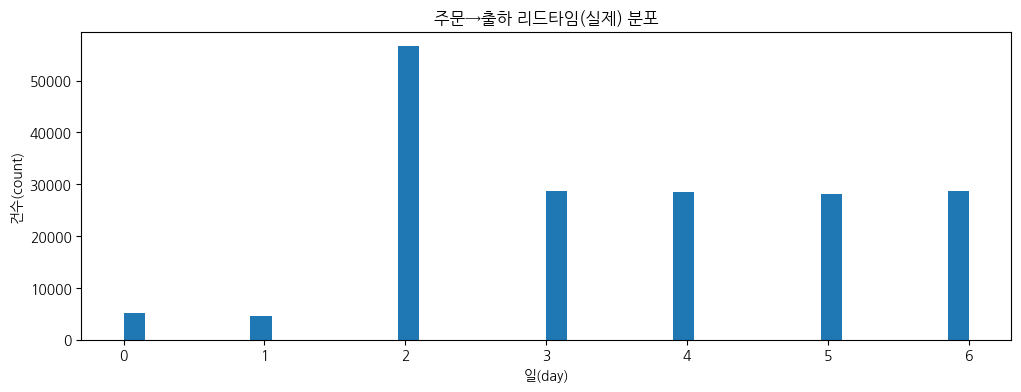

In [13]:
# 실 리드타임 분포 확인: 정상 범위/롱테일/이상치 감 잡기

vals = core_table["lt_real_days"].dropna()

plt.hist(vals, bins=40)
plt.title("주문→출하 리드타임(실제) 분포")
plt.xlabel("일(day)")
plt.ylabel("건수(count)")
plt.show()

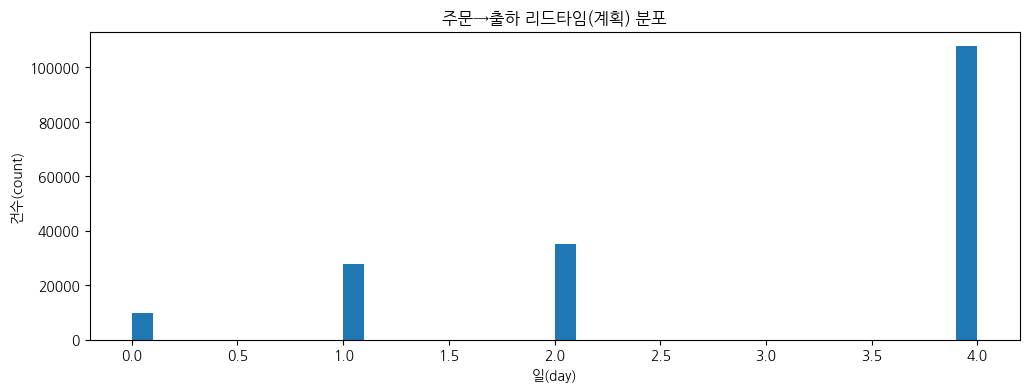

In [14]:
# 계획 리드타임 분포도 비교

if core_table["lt_sched_days"].notna().any():
    vals2 = core_table["lt_sched_days"].dropna()
    plt.hist(vals2, bins=40)
    plt.title("주문→출하 리드타임(계획) 분포")
    plt.xlabel("일(day)")
    plt.ylabel("건수(count)")
    plt.show()

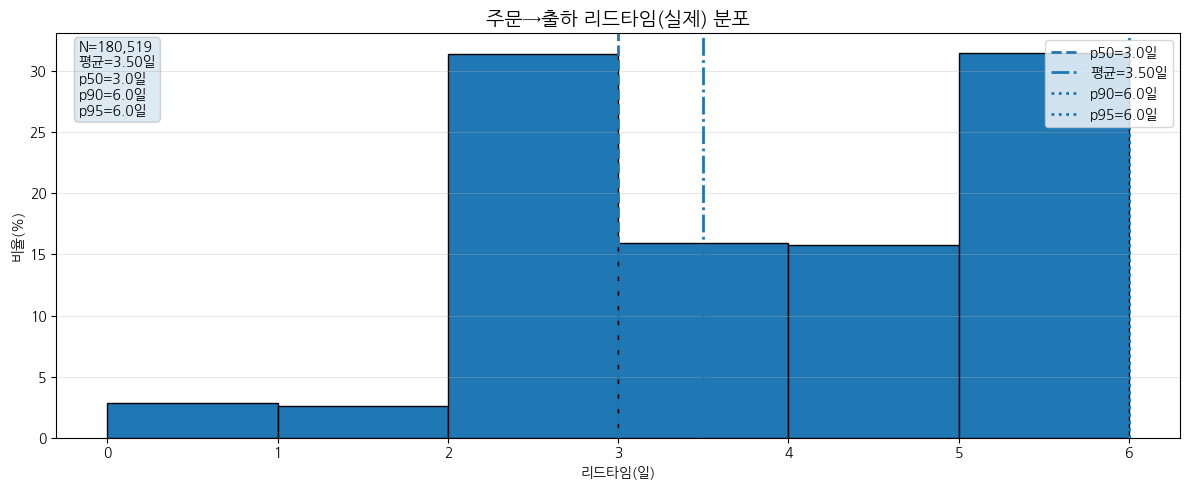

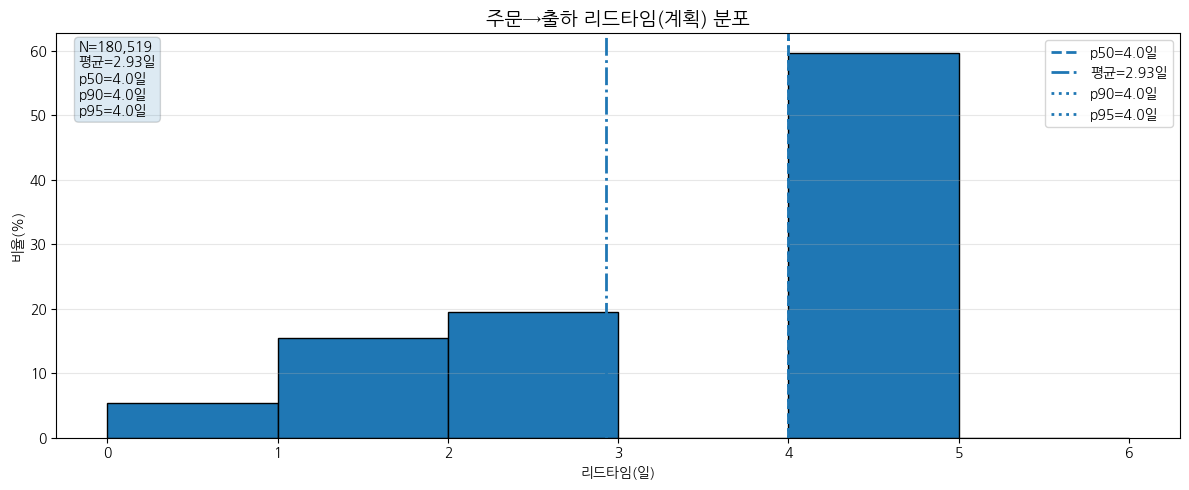

In [15]:
# 한눈에 보기


# 안전장치: 숫자형 변환 + 결측 제거
lt_real  = pd.to_numeric(core_table["lt_real_days"], errors="coerce").dropna()
lt_sched = pd.to_numeric(core_table["lt_sched_days"], errors="coerce").dropna()

#  공통 bin 생성 )
lo = np.floor(min(lt_real.min(), lt_sched.min())) if len(lt_sched) else np.floor(lt_real.min())
hi = np.ceil(max(lt_real.max(), lt_sched.max()))  if len(lt_sched) else np.ceil(lt_real.max())
bins = np.arange(lo, hi + 1)  # 일(day) 단위 bin

# 비율(%) 히스토그램을 위한 가중치
w_real  = np.ones_like(lt_real)  * (100.0 / len(lt_real))
w_sched = np.ones_like(lt_sched) * (100.0 / len(lt_sched)) if len(lt_sched) else None

# 요약 통계 (실제)
p50_r, p90_r, p95_r = np.percentile(lt_real, [50, 90, 95])
mean_r = lt_real.mean()

# --- 실제 리드타임 분포 ---
plt.figure(figsize=(12,5))
plt.hist(lt_real, bins=bins, weights=w_real, edgecolor="black")
plt.title("주문→출하 리드타임(실제) 분포", fontsize=14, fontweight="bold")
plt.xlabel("리드타임(일)")
plt.ylabel("비율(%)")
plt.grid(True, axis="y", alpha=0.3)


plt.axvline(p50_r,  linestyle="--", linewidth=2, label=f"p50={p50_r:.1f}일")
plt.axvline(mean_r, linestyle="-.", linewidth=2, label=f"평균={mean_r:.2f}일")
plt.axvline(p90_r,  linestyle=":",  linewidth=2, label=f"p90={p90_r:.1f}일")
plt.axvline(p95_r,  linestyle=":",  linewidth=2, label=f"p95={p95_r:.1f}일")

# 좌상단에 요약 박스
text_real = f"N={len(lt_real):,}\n평균={mean_r:.2f}일\np50={p50_r:.1f}일\np90={p90_r:.1f}일\np95={p95_r:.1f}일"
plt.gca().text(0.02, 0.98, text_real, transform=plt.gca().transAxes,
               va="top", ha="left", bbox=dict(boxstyle="round", alpha=0.15))

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 4) 요약 통계 (계획) + 그래프 (데이터가 있을 때만)
if len(lt_sched):
    p50_s, p90_s, p95_s = np.percentile(lt_sched, [50, 90, 95])
    mean_s = lt_sched.mean()

    plt.figure(figsize=(12,5))
    plt.hist(lt_sched, bins=bins, weights=w_sched, edgecolor="black")
    plt.title("주문→출하 리드타임(계획) 분포", fontsize=14, fontweight="bold")
    plt.xlabel("리드타임(일)")
    plt.ylabel("비율(%)")
    plt.grid(True, axis="y", alpha=0.3)

    plt.axvline(p50_s,  linestyle="--", linewidth=2, label=f"p50={p50_s:.1f}일")
    plt.axvline(mean_s, linestyle="-.", linewidth=2, label=f"평균={mean_s:.2f}일")
    plt.axvline(p90_s,  linestyle=":",  linewidth=2, label=f"p90={p90_s:.1f}일")
    plt.axvline(p95_s,  linestyle=":",  linewidth=2, label=f"p95={p95_s:.1f}일")

    text_sched = f"N={len(lt_sched):,}\n평균={mean_s:.2f}일\np50={p50_s:.1f}일\np90={p90_s:.1f}일\np95={p95_s:.1f}일"
    plt.gca().text(0.02, 0.98, text_sched, transform=plt.gca().transAxes,
                   va="top", ha="left", bbox=dict(boxstyle="round", alpha=0.15))

    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 계획 리드타임(lt_sched_days) 데이터가 없어 계획 분포 그래프는 생략합니다.")

- 실제 배송은 다양하게 퍼져 있고, 특히 2일이 가장 흔한 패턴.
- 계획은 주로 4일 기준으로 잡혀 있었음. (3일은 거의 없음)

### 2-3) 월별 OTD 추이 + 평균 리드타임 추이

  - OTD = On Time Delivery (제시간 배송률)
     :전체 주문 중에서 계획보다 늦지 않게 출하된 비율


  
  - 평균 리드타임 추이 : 매달 실제로 평균 몇 일이 걸렸는지 보여줌

In [16]:
#  core_table 필요 컬럼 추가

core_table["order_date"] = pd.to_datetime(core_table["order_date"], errors="coerce")
core_table["lt_real_days"] = pd.to_numeric(core_table["lt_real_days"], errors="coerce")
core_table["otd_flag"] = pd.to_numeric(core_table["otd_flag"], errors="coerce").fillna(0).astype(int)

In [17]:
# 월 단위 KPI 집계 (분석 기본 테이블)

monthly_kpi = (
    core_table
    .groupby(core_table["order_date"].dt.to_period("M"))
    .agg(order_count=("order_id", "count"),
         otd_rate=("otd_flag", "mean"),
         avg_leadtime=("lt_real_days", "mean"))
    .reset_index()
    .rename(columns={"order_date": "month"})
    .sort_values("month")
    .reset_index(drop=True)
)
monthly_kpi["month_str"] = monthly_kpi["month"].astype(str)

In [18]:
# 월별 리드타임 퍼센타일(=백분위수) (분포 확인용)
#   - p50/p90/p95: 분포의 들쭉날쭉(변동성)을 평균과 함께 확인


monthly_q = (
    core_table
    .groupby(core_table["order_date"].dt.to_period("M"))["lt_real_days"]
    .quantile([0.5, 0.9, 0.95])
    .unstack()
    .reset_index()
    .rename(columns={"order_date":"month", 0.5:"p50", 0.9:"p90", 0.95:"p95"})
    .sort_values("month")
    .reset_index(drop=True)
)
monthly_q["month_str"] = monthly_q["month"].astype(str)

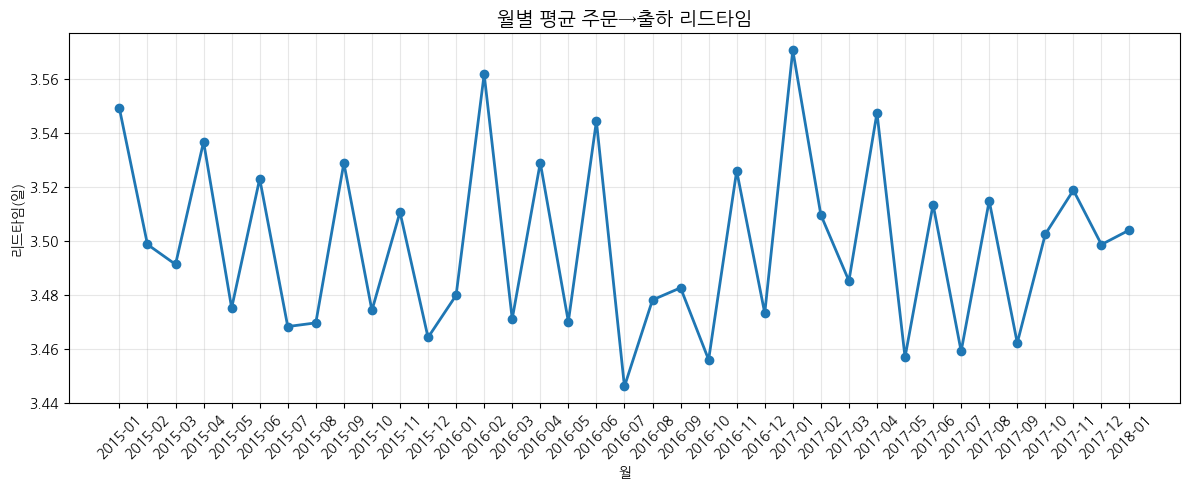

In [19]:
# 월별 평균 리드타임

plt.figure(figsize=(12,5))
plt.plot(monthly_kpi["month_str"], monthly_kpi["avg_leadtime"], marker="o", linewidth=2)
plt.title("월별 평균 주문→출하 리드타임", fontsize=14, fontweight="bold")
plt.xlabel("월")
plt.ylabel("리드타임(일)")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

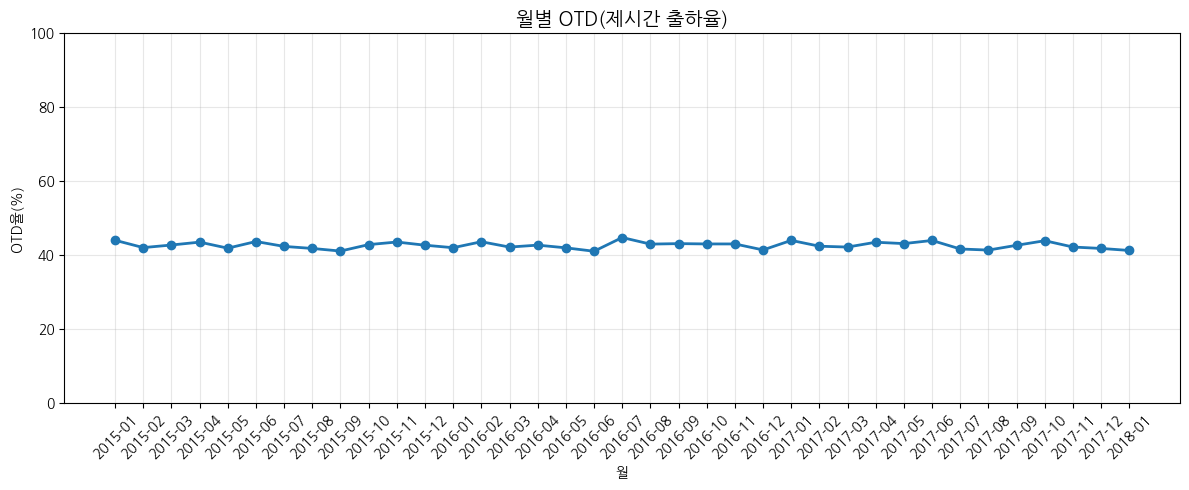

In [20]:
# 월별 OTD율

y_otd_pct = monthly_kpi["otd_rate"] * 100  # 0~100%로 변환

plt.figure(figsize=(12,5))
plt.plot(monthly_kpi["month_str"], y_otd_pct, marker="o", linewidth=2)
plt.title("월별 OTD(제시간 출하율)", fontsize=14, fontweight="bold")
plt.xlabel("월")
plt.ylabel("OTD율(%)")
plt.ylim(0, 100)  # 보고용: 0~100 고정
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# +) 월별 OTD율 (확대버전)

# OTD 확대축 자동 계산

def auto_ylim_percent(y_percent, pad=2.0, min_span=6.0):
    y = np.asarray(y_percent)
    lo = max(0,  np.floor(y.min() - pad))
    hi = min(100, np.ceil(y.max() + pad))
    if (hi - lo) < min_span:
        mid = (hi + lo) / 2
        lo = max(0, mid - min_span/2)
        hi = min(100, mid + min_span/2)
    return lo, hi

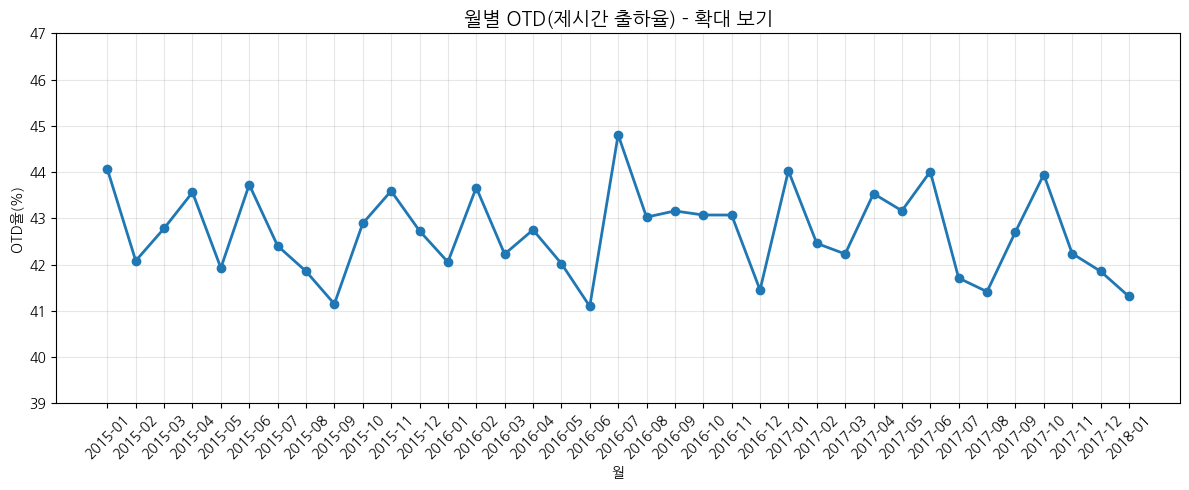

In [22]:
lo, hi = auto_ylim_percent(y_otd_pct.values)  # 자동 구간 계산

plt.figure(figsize=(12,5))
plt.plot(monthly_kpi["month_str"], y_otd_pct, marker="o", linewidth=2)
plt.title("월별 OTD(제시간 출하율) - 확대 보기", fontsize=14, fontweight="bold")
plt.xlabel("월")
plt.ylabel("OTD율(%)")
plt.ylim(lo, hi)  # 분석용: 자동 확대
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

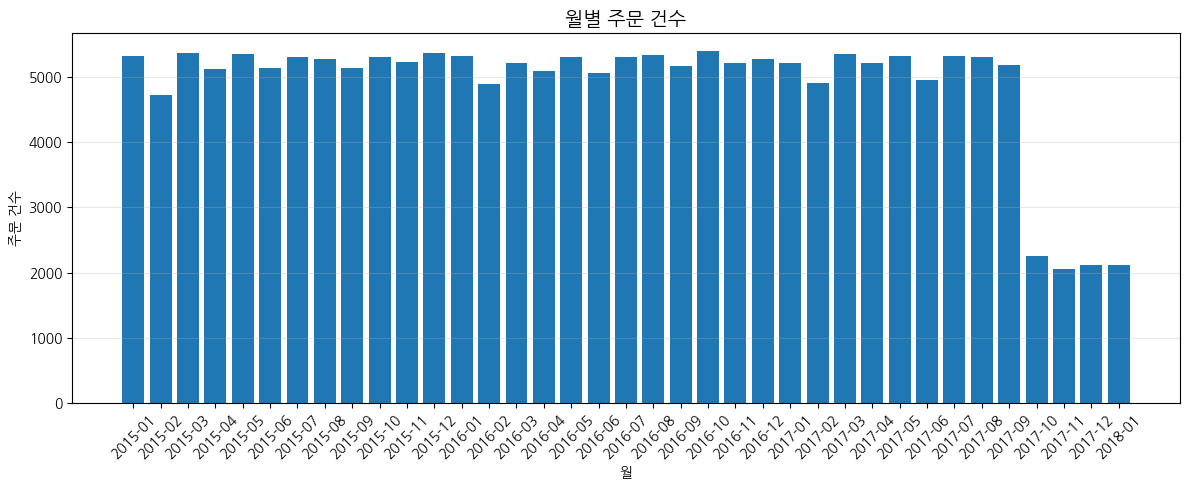

In [23]:
# 월별 주문 건수 (막대)

plt.figure(figsize=(12,5))
plt.bar(monthly_kpi["month_str"], monthly_kpi["order_count"])
plt.title("월별 주문 건수", fontsize=14, fontweight="bold")
plt.xlabel("월")
plt.ylabel("주문 건수")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1790790428.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


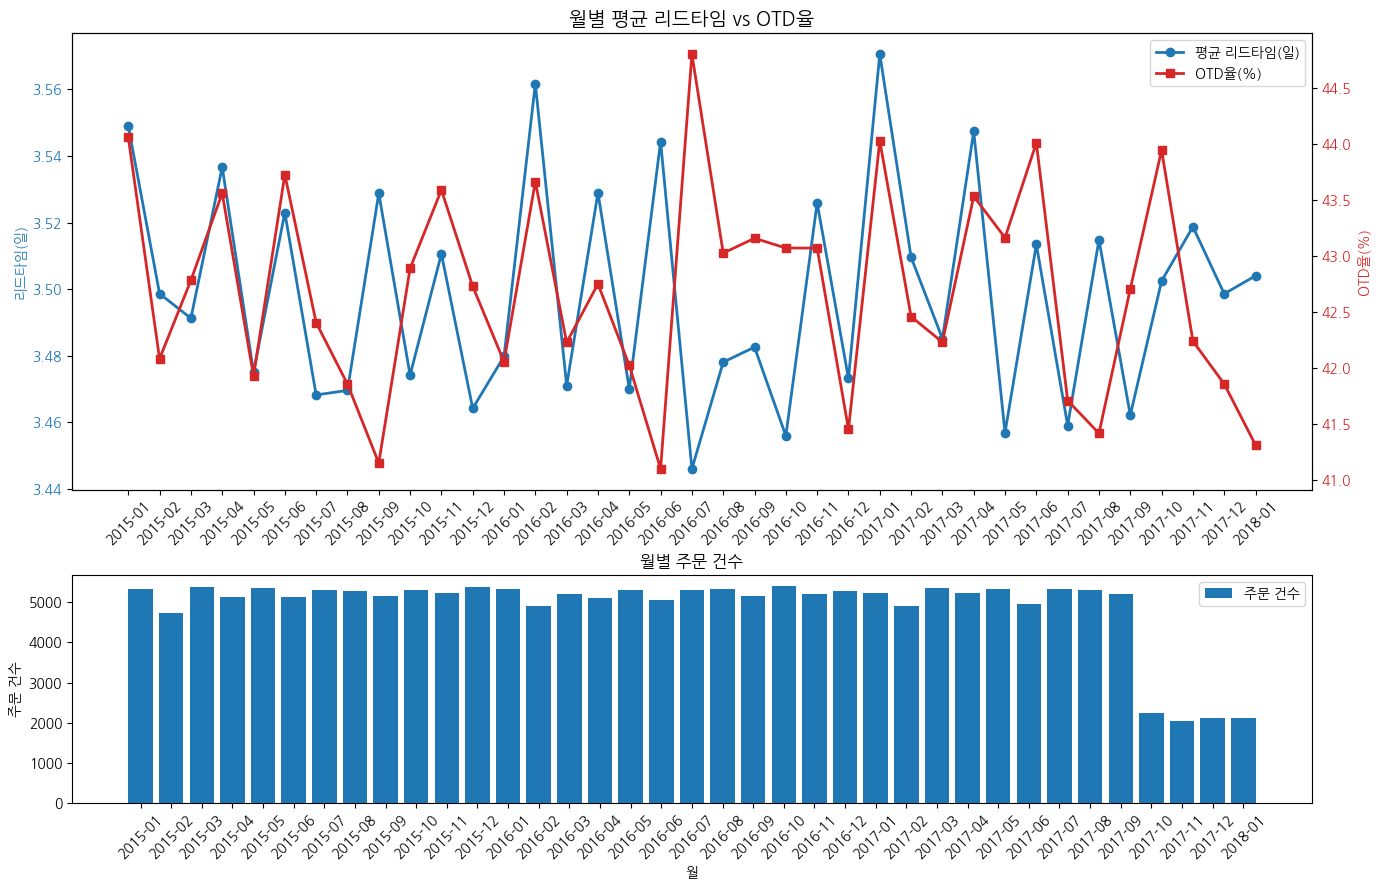

In [24]:
# 한눈에 보기


# 대시보드 캔버스 만들기 (2행 1열)
#   - 위: 평균 리드타임 vs OTD율 (이중축)
#   - 아래: 주문 건수 (막대)
# ------------------------------------------------------------

fig = plt.figure(figsize=(16, 10))
grid = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.25)


# [1] 위 패널: 평균 리드타임(좌) + OTD율(우)

ax1 = fig.add_subplot(grid[0, 0])

# 왼쪽 Y축: 평균 리드타임(일)
ax1.plot(monthly_kpi["month_str"], monthly_kpi["avg_leadtime"],
         marker="o", linewidth=2, label="평균 리드타임(일)", color="tab:blue")
ax1.set_ylabel("리드타임(일)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# 오른쪽 Y축: OTD율(%)
ax2 = ax1.twinx()
ax2.plot(monthly_kpi["month_str"], monthly_kpi["otd_rate"] * 100,
         marker="s", linewidth=2, label="OTD율(%)", color="tab:red")
ax2.set_ylabel("OTD율(%)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# 제목/축/눈금 공통 정리
ax1.set_title("월별 평균 리드타임 vs OTD율", fontsize=14, fontweight="bold")
ax1.set_xlabel("")  # 위 패널은 X축 라벨 생략
ax1.tick_params(axis="x", rotation=45)

# 좌/우 축 범례 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")


# [2] 아래 패널: 월별 주문 건수 (막대)
# ------------------------
ax3 = fig.add_subplot(grid[1, 0])

ax3.bar(monthly_kpi["month_str"], monthly_kpi["order_count"], label="주문 건수")
ax3.set_title("월별 주문 건수", fontsize=12, fontweight="bold")
ax3.set_xlabel("월")
ax3.set_ylabel("주문 건수")
ax3.tick_params(axis="x", rotation=45)
ax3.legend(loc="upper right")

fig.tight_layout()
plt.show()

<확인할 수 있는것>

1. 제시간 배송률(OTD) 대부분 41~45% 범위에서 움직임.

    ➡ 절반 이상이 제시간을 못 지킨다는 걸 확인할 수 있음.

2. 평균 리드타임은 3.45~3.56일로 월별 변동이 작음.

    ➡ 평균은 안정적이지만 지연율 개선과는 별개임.

3. 계획 리드타임은 대체로 4일로 고정, 실제는 2~6일로 넓게 분포.

    ➡ 고정된 계획값이 현실과 괴리되어 지연 판정이 구조적으로 많이 발생.

4. p95(실제 리드타임) 약 6일.

    ➡ 95%는 6일 내 출하되지만, 상위 5% ‘꼬리 지연'이 반복됨.

5. 리드타임이 늘어난 달에는 OTD가 낮아지는 경향(음의 관계).

    ➡ 처리 속도 악화가 약속 준수율 하락으로 직결됨.


: 장기 추세로는 OTD의 의미 있는 상승이 없음.

  ➡ 개선 활동이 누적·표준화되지 않음 또는 KPI가 평균 위주라 문제 구간이 숨겨짐.

<할 수 있는 것>
1. 문제 구간 찾기: 운송모드·지역·카테고리별로 OTD% / p95(일)를 뽑아 Top 지연 구간부터 집중.

2. 계획값 손보기: 각 구간의 p90~p95 기준으로 계획 리드타임 재설정(비현실적 계획 제거).

3. 피크 대비: 물량 급증 달은 버퍼·증차·우회 노선 미리 확보.

4. 사전 경보: 출고 전 지연 위험 예측(간단 분류모델)로 우선 처리.

5. KPI 재정의: 평균 대신 OTD%(높을수록 좋음) + p95(짧을수록 좋음)를 공식 지표로 관리.

### 2-4) 어디에서 지연이 많은가? (차원별 Top N) = 문제구간 찾기

In [25]:
# @title
# 그룹별 지연율 테이블
## 개선 우선순위를 잡기 위해 Top N을 봄

def build_late_table(table, group_col, top=10, min_count=100):
    g = (table.groupby(group_col)
         .agg(lines=("order_id","count"),
              late_rate=("late_flag","mean"),
              otd_rate=("otd_flag","mean"),
              avg_real_lt=("lt_real_days","mean"))
         .sort_values("late_rate", ascending=False))

    return g[g["lines"] >= min_count].head(top).round(3) # 표본이 너무 적은 그룹은 제외(신뢰도 확보)

late_by_mode    = build_late_table(core_table, "shipping_mode", top=10, min_count=50)
late_by_region  = build_late_table(core_table, "order_region",  top=10, min_count=100)
late_by_country = build_late_table(core_table, "order_country", top=10, min_count=100)
late_by_cat     = build_late_table(core_table, "category_name", top=10, min_count=100)

display(late_by_mode)
display(late_by_region)
display(late_by_country)
display(late_by_cat)

,lines,late_rate,otd_rate,avg_real_lt
shipping_mode,,,,
First Class,27814,1.000,0.000,2.000
Second Class,35216,0.797,0.203,3.991
Same Day,9737,0.478,0.522,0.478
Standard Class,107752,0.398,0.602,3.996


,lines,late_rate,otd_rate,avg_real_lt
order_region,,,,
Central Africa,1677,0.607,0.393,3.561
Western Europe,27109,0.585,0.415,3.498
South Asia,7731,0.585,0.415,3.502
South of USA,4045,0.581,0.419,3.493
Southeast Asia,9539,0.580,0.420,3.497
East of USA,6915,0.580,0.420,3.501
West Asia,6009,0.575,0.425,3.487
East Africa,1852,0.575,0.425,3.515
Eastern Europe,3920,0.574,0.426,3.501


,lines,late_rate,otd_rate,avg_real_lt
order_country,,,,
Ecuador,294,0.694,0.306,3.340
Níger,108,0.667,0.333,3.972
Mozambique,244,0.664,0.336,3.730
Irlanda,491,0.648,0.352,3.491
Trinidad y Tobago,138,0.645,0.355,4.138
Hungría,179,0.642,0.358,3.844
Somalia,141,0.638,0.362,2.979
Ghana,264,0.636,0.364,3.860
Angola,306,0.627,0.373,3.402


,lines,late_rate,otd_rate,avg_real_lt
category_name,,,,
Lacrosse,343,0.621,0.379,3.618
Cameras,592,0.620,0.380,3.338
Pet Supplies,492,0.614,0.386,3.388
Sporting Goods,357,0.599,0.401,3.490
Fitness Accessories,309,0.595,0.405,3.573
Crafts,484,0.595,0.405,3.579
Strength Training,111,0.595,0.405,3.748
Music,434,0.594,0.406,3.484
Boxing & MMA,423,0.593,0.407,3.468


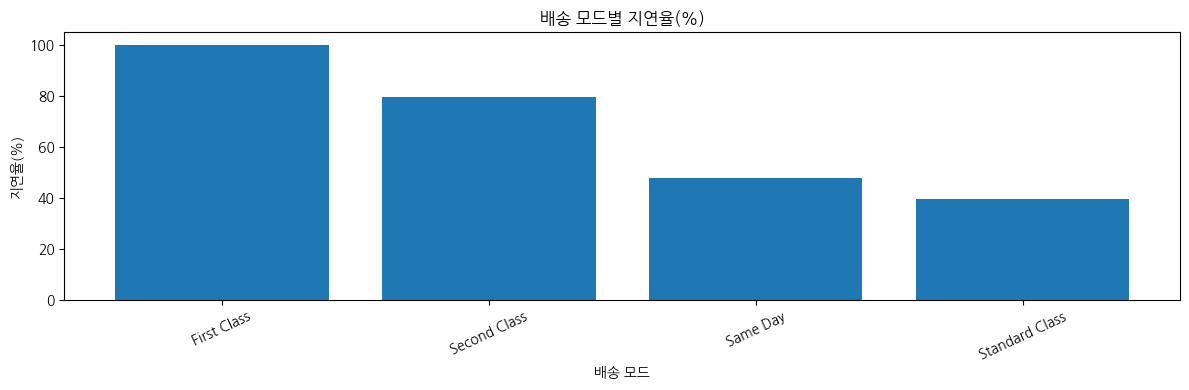

In [ ]:
# 배송 모드별 지연율 그래프

if len(late_by_mode) > 0:
    order_idx = late_by_mode.sort_values("late_rate", ascending=False).index
    values = (late_by_mode.loc[order_idx, "late_rate"] * 100).values

    plt.bar(order_idx, values)
    plt.title("배송 모드별 지연율(%)")
    plt.xlabel("배송 모드")
    plt.ylabel("지연율(%)")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

### 2-5) 파레토 분석(상위 그룹이 지연 대부분을 유발?)

In [26]:
# 안전장치: late_flag 숫자형
core_table["late_flag"] = pd.to_numeric(core_table["late_flag"], errors="coerce").fillna(0).astype(int)

In [27]:
# 국가별 지연건수 집계 + 누적비중 계산 (파레토용 테이블)
late_by_country_count = (
    core_table
    .groupby("order_country", dropna=False)
    .agg(late_cnt=("late_flag", "sum"), # 지연 '건수'
         orders=("order_id", "count")) # 전체 주문건(참고)
    .reset_index()
    .sort_values("late_cnt", ascending=False)
    .reset_index(drop=True)
)

total_late = late_by_country_count["late_cnt"].sum()
late_by_country_count["cum_cnt"] = late_by_country_count["late_cnt"].cumsum()
late_by_country_count["cum_pct"] = late_by_country_count["cum_cnt"] / total_late  # 0~1

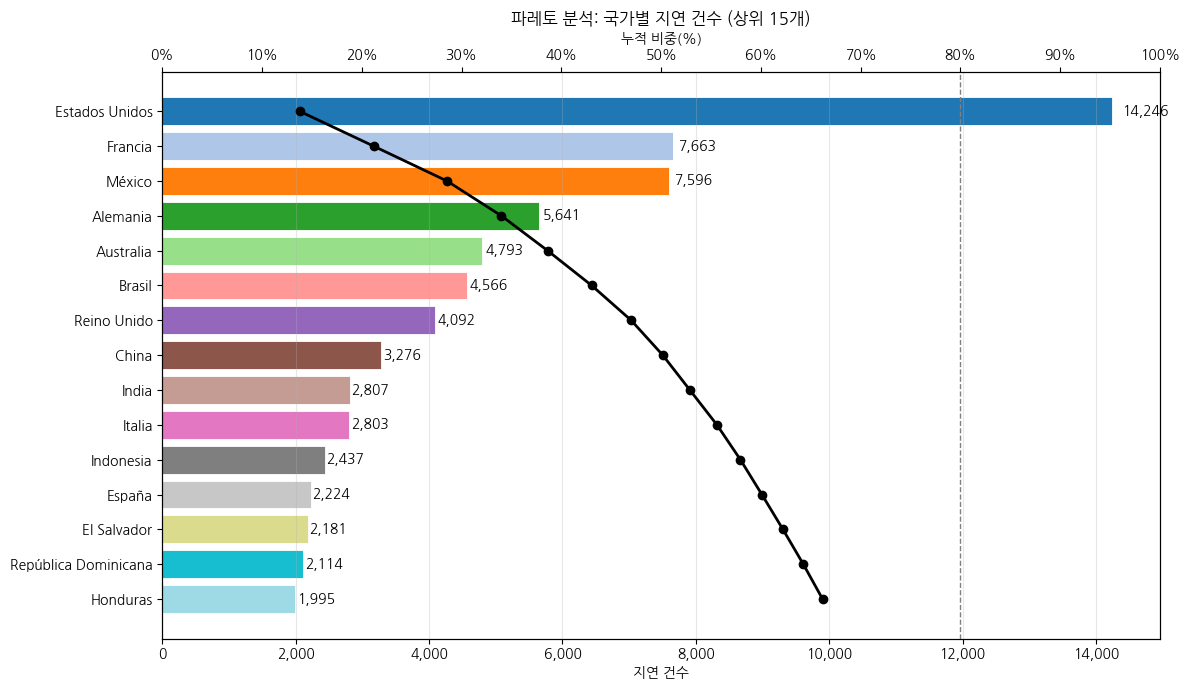

In [28]:
# 상위 N개만 시각화
TOP_N = 15
df_top = late_by_country_count.head(TOP_N).copy()

countries   = df_top["order_country"]
late_counts = df_top["late_cnt"].values
cum_pct     = (df_top["cum_pct"] * 100).values

# 파레토 차트 (가로막대 + 누적비중 라인)
fig, ax1 = plt.subplots(figsize=(12, 7))

ypos = np.arange(len(countries))
palette = plt.cm.tab20(np.linspace(0, 1, len(countries)))
bars = ax1.barh(ypos, late_counts, color=palette, edgecolor="white", linewidth=0.6)

ax1.set_yticks(ypos)
ax1.set_yticklabels(countries)
ax1.invert_yaxis()
ax1.set_xlabel("지연 건수")
ax1.set_title("파레토 분석: 국가별 지연 건수 (상위 15개)")
ax1.grid(axis="x", alpha=0.3)
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

# 막대 끝에 값 라벨(가독성↑)
for i, v in enumerate(late_counts):
    ax1.text(v * 1.01, i, f"{int(v):,}", va="center")


ax2 = ax1.twiny()
ax2.plot(cum_pct, ypos, color="black", marker="o", linewidth=2, label="누적 비중(%)")
ax2.set_xlim(0, 100)
ax2.set_xlabel("누적 비중(%)")
ax2.xaxis.set_major_formatter(PercentFormatter(xmax=100))
ax2.set_xticks(np.arange(0, 101, 10))

# 80% 기준선 + 도달 지점 표시
ax2.axvline(80, color="gray", linestyle="--", linewidth=1)
idx80 = np.argmax(cum_pct >= 80) if np.any(cum_pct >= 80) else None
if idx80 is not None:
    ax2.scatter(cum_pct[idx80], ypos[idx80], color="red", zorder=5)
    ax2.annotate(
        f"상위 {idx80+1}개 국가가 80% 도달",
        xy=(cum_pct[idx80], ypos[idx80]),
        xytext=(min(95, cum_pct[idx80] + 8), ypos[idx80] + 0.5),
        arrowprops=dict(arrowstyle="->", color="red"),
        ha="left", va="center", color="red"
    )

plt.tight_layout()
plt.show()

- 막대: 지연 건수가 많은 국가 순.

- 검은 선(누적 비중): 위에서부터 합쳤을 때 전체 지연의 누적 %.
----------------------------------------------
- 미국(Estados Unidos) 한 나라가 전체 지연의 30~40% 이상 기여.

- 상위 3~5개 국가가 50% 이상.

- 80% 도달에 약 9~10개국 필요(차트의 빨간 점).

(액션)

- 이 국가 우선 개선 → SLA/운송루트/통관/협력사 점검.

- 하위 긴 꼬리 국가는 “표준 프로세스 유지” 정도면 충분.

#3.원인분석

In [29]:
# 교차분석: 지역 × 배송모드 별 지연율 → 어느 조합이 특히 안 좋은지 확인

cross_late_table = pd.pivot_table(
    core_table,
    values="late_flag",
    index="order_region",
    columns="shipping_mode",
    aggfunc="mean"
).round(3)

cross_late_table

shipping_mode,First Class,Same Day,Second Class,Standard Class
order_region,,,,
Canada,1.0,0.333,0.771,0.304
Caribbean,1.0,0.534,0.819,0.372
Central Africa,1.0,0.304,0.825,0.449
Central America,1.0,0.487,0.784,0.402
Central Asia,1.0,0.203,0.906,0.434
East Africa,1.0,0.418,0.787,0.412
East of USA,1.0,0.483,0.787,0.415
Eastern Asia,1.0,0.485,0.838,0.387
Eastern Europe,1.0,0.360,0.754,0.410


# 4. 수요예측(Prophet) + MRP 시뮬레이션

## 1) EDA/정제 → 주간 시계열 만들기 (부분주 제거 포함)
예측과 MRP는 '주간' 단위를 기본으로 돌리기 좋음

In [67]:
# 타입 정리
core_table["order_date"] = pd.to_datetime(core_table["order_date"], errors="coerce")
core_table["order_qty"]  = pd.to_numeric(core_table["order_qty"], errors="coerce")
core_table = core_table.dropna(subset=["order_date", "order_qty"])

In [68]:
# 주키: W-SUN (주말=일요일) → 주간 수요 집계
##    MRP/예측은 '주' 단위가 다루기 쉬움

core_table["week_key"] = core_table["order_date"].dt.to_period("W-SUN")

weekly_demand = (
    core_table.groupby("week_key")["order_qty"]
    .sum()
    .sort_index()
    .to_frame(name="demand")
)

In [69]:
# '부분주' 제거: 마지막 주가 7일이 꽉 차지 않으면 제외하여 왜곡 방지
last_order_date = core_table["order_date"].max()
last_week_start = weekly_demand.index[-1].start_time  # 이 주의 월요일

if (last_order_date - last_week_start).days < 6:
    weekly_demand = weekly_demand.iloc[:-1]

In [70]:
# Prophet 시각화를 위해 컬럼 추가

weekly_demand["ds"] = weekly_demand.index.to_timestamp(how="end")  # 일요일
weekly_demand["y"]  = weekly_demand["demand"].astype(float)

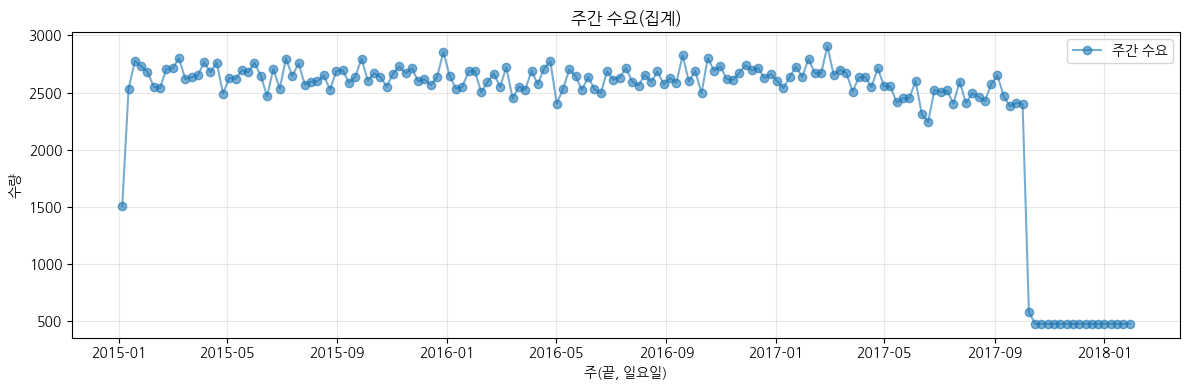

In [71]:
# 참고용 그래프
plt.figure(figsize=(12,4))
plt.plot(weekly_demand["ds"], weekly_demand["y"], marker="o", alpha=0.6, label="주간 수요")
plt.title("주간 수요(집계)")
plt.xlabel("주(끝, 일요일)")
plt.ylabel("수량")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 2)꼬리(급락) 구간 자동 감지 → 컷 → wd_valid 생성
2017 9월 쯤? 이후의 데이터 급락현상

In [72]:
# 안정 기준 추정(초기 52주 중앙값)
wd = weekly_demand[["ds","y"]].sort_values("ds").reset_index(drop=True).copy()
N_base = 52
base_med = wd["y"].iloc[:max(N_base, 1)].median()

In [73]:
# 급락 판정: 기준의 ratio(예: 35%) 이하가 K주 연속이면 '붕괴 시작'
ratio = 0.35
K = 6
wd["too_low"] = wd["y"] <= (base_med * ratio)
wd["low_run"] = wd["too_low"].rolling(window=K, min_periods=K).sum().ge(K)

collapse_idx = wd.index[wd["low_run"]].min() if wd["low_run"].any() else None
valid_end_ds = wd.loc[collapse_idx - 1, "ds"] if collapse_idx is not None else wd["ds"].max()

print("유효 데이터 종료:", valid_end_ds.date(), "| 붕괴 탐지됨:", collapse_idx is not None)

유효 데이터 종료: 2017-11-05 | 붕괴 탐지됨: True


In [74]:
# 유효 구간만 사용
wd_valid = wd[wd["ds"] <= valid_end_ds].copy().reset_index(drop=True)

## 3) 수요 예측 (Prophet) – 4~8주 앞
- wd_valid 기준, HORIZON주 앞 (급락판정 제외한 유효구간만)
- Prophet으로 과거 데이터 학습 후 미래 HORIZON주 예측

In [75]:
HORIZON = 8  # 예측할 주 수 (조정가능 : 8주로 설정)

# Prophet 모델 적합
m = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=True)
m.fit(wd_valid.rename(columns={"ds":"ds","y":"y"}))

# 미래 주차 프레임 생성 & 예측
future   = m.make_future_dataframe(periods=HORIZON, freq="W")  # W = W-SUN
forecast = m.predict(future)[["ds","yhat","yhat_lower","yhat_upper"]]

# 과거=실제, 미래=예측으로 plan 구성
demand_plan = wd_valid.merge(forecast, on="ds", how="right")
demand_plan["plan"] = demand_plan["y"].fillna(demand_plan["yhat"]).clip(lower=0)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk851k4bb/_xu5lcza.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk851k4bb/g3pqfxmp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81454', 'data', 'file=/tmp/tmpk851k4bb/_xu5lcza.json', 'init=/tmp/tmpk851k4bb/g3pqfxmp.json', 'output', 'file=/tmp/tmpk851k4bb/prophet_modelgwgvsp7l/prophet_model-20250925004943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:49:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:49:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


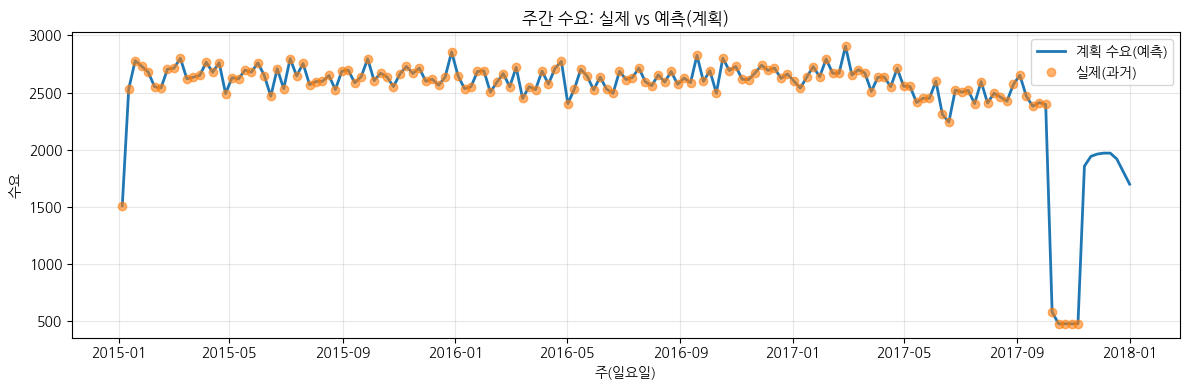

In [76]:
plt.figure(figsize=(12,4))
plt.plot(demand_plan["ds"], demand_plan["plan"], label="계획 수요(예측)", linewidth=2)
plt.plot(wd_valid["ds"], wd_valid["y"], marker="o", linestyle="", alpha=0.6, label="실제(과거)")
plt.title("주간 수요: 실제 vs 예측(계획)")
plt.xlabel("주(일요일)")
plt.ylabel("수요")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 4). 예측 정확도 평가 (홀드아웃: 마지막 N주)
마지막 TEST_WEEKS를 테스트로 잡아 성능 평가(MAPE/sMAPE/RMSE/MAE)

In [78]:
TEST_WEEKS = 12  # 테스트 구간 길이

data  = wd_valid.copy()
train = data.iloc[:-TEST_WEEKS]
test  = data.iloc[-TEST_WEEKS:]

print(f"Train: {train['ds'].min().date()} ~ {train['ds'].max().date()}  |  "
      f"Test: {test['ds'].min().date()} ~ {test['ds'].max().date()}")

Train: 2015-01-04 ~ 2017-08-13  |  Test: 2017-08-20 ~ 2017-11-05


In [79]:
# 학습
m_eval = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=True)
m_eval.fit(train.rename(columns={"ds":"ds","y":"y"}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk851k4bb/g8i2e0ev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk851k4bb/l2wbrf8v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2474', 'data', 'file=/tmp/tmpk851k4bb/g8i2e0ev.json', 'init=/tmp/tmpk851k4bb/l2wbrf8v.json', 'output', 'file=/tmp/tmpk851k4bb/prophet_modeltrrynjfc/prophet_model-20250925005235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:52:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [80]:
# 테스트 길이만큼 예측
future_eval = m_eval.make_future_dataframe(periods=TEST_WEEKS, freq="W")
fcst_eval   = m_eval.predict(future_eval)[["ds","yhat"]]

# 앵커 동일(W-SUN)이므로 그대로 병합
eval_df = (test.merge(fcst_eval, on="ds", how="left")
                .rename(columns={"y":"actual","yhat":"pred"})
                .dropna(subset=["actual","pred"]))

In [81]:
# 지표 함수
def mape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    mask = np.abs(y_true) > eps
    return np.mean(np.abs((y_true[mask]-y_pred[mask]) / y_true[mask]))*100 if mask.any() else np.nan

def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    denom = (np.abs(y_true)+np.abs(y_pred))+eps
    return np.mean(2*np.abs(y_pred-y_true)/denom)*100

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    return float(np.sqrt(np.mean((y_true-y_pred)**2)))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    return float(np.mean(np.abs(y_true - y_pred)))

metrics = {
    "MAPE(%)" : round(mape(eval_df["actual"], eval_df["pred"]), 2),
    "sMAPE(%)": round(smape(eval_df["actual"], eval_df["pred"]), 2),
    "RMSE"    : round(rmse(eval_df["actual"],  eval_df["pred"]),  2),
    "MAE"     : round(mae(eval_df["actual"],   eval_df["pred"]),  2),
}
display(pd.DataFrame([metrics]))

,MAPE(%),sMAPE(%),RMSE,MAE
0,173.15,58.55,1313.86,913.06


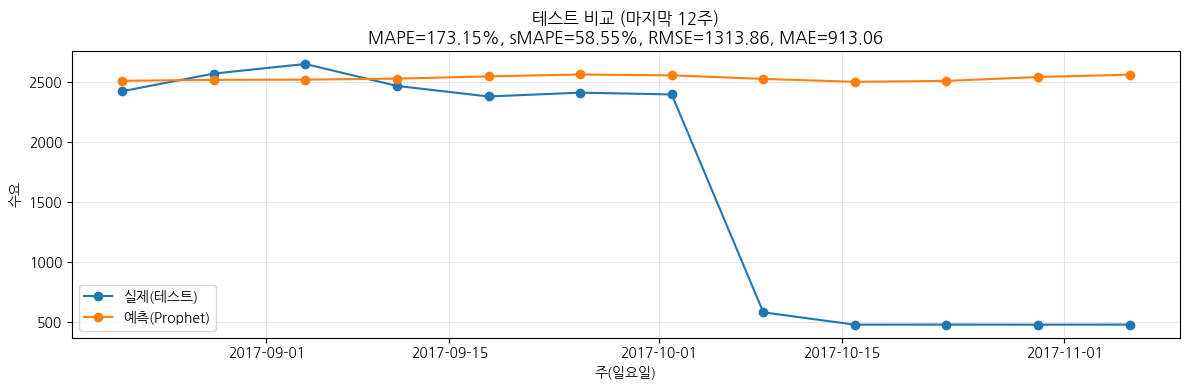

In [82]:
plt.figure(figsize=(12,4))
plt.plot(eval_df["ds"], eval_df["actual"], marker="o", label="실제(테스트)")
plt.plot(eval_df["ds"], eval_df["pred"],   marker="o", label="예측(Prophet)")
plt.title(f"테스트 비교 (마지막 {TEST_WEEKS}주)\n"
          f"MAPE={metrics['MAPE(%)']}%, sMAPE={metrics['sMAPE(%)']}%, "
          f"RMSE={metrics['RMSE']}, MAE={metrics['MAE']}")
plt.xlabel("주(일요일)")
plt.ylabel("수요")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 5)(검증된 예측으로) MRP 시뮬레이션

In [84]:
# 정책 파라미터 (임의의 값 넣음)

current_stock = 1000   # 시작 재고
leadtime_w    = 2      # 리드타임(주)
service_level = 0.95   # 목표 서비스레벨
moq           = 0      # 최소주문수량(없으면 0)

In [85]:
# 안전재고(간이): z * sigma * sqrt(LT)
z = 1.645 if service_level >= 0.95 else 1.28
sigma = wd_valid["y"].tail(12).std(ddof=0)          # 최근 12주 변동성
safety_stock = max(0, int(round(z * sigma * np.sqrt(max(1, leadtime_w)))))

# ROP & S(보충목표)
avg_weekly = wd_valid["y"].tail(12).mean()
ROP = int(round(avg_weekly * leadtime_w + safety_stock))
S_level = int(round(ROP + avg_weekly * 1))  # 리뷰주기 1주

print(f"안전재고≈{safety_stock:,} | ROP≈{ROP:,} | S≈{S_level:,}")

안전재고≈2,270 | ROP≈5,572 | S≈7,223


ROP 공식: ROP = (평균주간수요 × LT) + 안전재고

    ▶(5572−2270)/2 =1651 개/주
    이지만 그래프상 과거 정상구간 수요는 2,400~2,700/주 수준

  최근 12주 평균을 썼거나, 컷 구간/완만한 하강 구간이 섞여 평균이 과소 추정되었을 가능성이 큼

  평균수요가 낮게 잡히면 ROP도 낮아져야 하는데, 지금은 높은 안전재고 덕분에 Fill Rate가 99%까지 올라간 상태(= 과보수적 재고일 수 있음).


In [91]:
# 위에 확인용
# 1. ROP에서 역산된 평균주간수요 (지금 시뮬 결과 기준)
implied_avg = (5572 - 2270) / 2  # ≈ 1651

# 2. 우리가 ROP 계산에 실제 사용한 평균
avg_used = wd_valid["y"].tail(12).mean()  # 또는 너가 사용한 윈도우

# 3. 정상구간 중앙값(더 튼튼)
median_stable = wd_valid["y"].iloc[:52].median()  # 초기 1년 등

# 4. 다음 LT 2주 예측합(동적 ROP 대안)
next_lt_demand = demand_plan.set_index("ds")["plan"].rolling(2).sum().shift(-1)

print(avg_used)

1650.8333333333333


In [86]:
def mrp_simulate(series_ds, demand_plan, start_stock, leadtime_w, ROP, S_level, moq=0):
    on_hand  = start_stock
    pipeline = {}  # key=도착주 index, val=입고량
    rows = []
    for t, (ds, dem) in enumerate(zip(series_ds, demand_plan)):

        # 도착 입고 반영
        receipt = pipeline.pop(t, 0)
        on_hand += receipt

        # 수요 차감
        ship = min(on_hand, dem)
        lost = max(0, dem - ship)
        on_hand -= ship

        # 발주 판단
        order_qty = 0
        if on_hand <= ROP:
            target = max(S_level - on_hand, 0)

            if moq > 0:
                target = int(moq * np.ceil(target / moq))
            order_qty = target

            if order_qty > 0:
                pipeline[t + leadtime_w] = pipeline.get(t + leadtime_w, 0) + order_qty

        rows.append({
            "week": ds, "demand": dem, "ship": ship, "lost": lost,
            "receipt": receipt, "on_hand": on_hand, "order_qty": order_qty
        })
    return pd.DataFrame(rows)

In [87]:
# 시뮬레이션 (과거+예측 전체 기간)

sim = mrp_simulate(
    demand_plan["ds"].values,
    demand_plan["plan"].values,
    start_stock=current_stock,
    leadtime_w=leadtime_w,
    ROP=ROP, S_level=S_level, moq=moq
)

In [88]:

# KPI
fill_rate     = 1 - (sim["lost"].sum() / sim["demand"].sum())
orders_placed = int((sim["order_qty"] > 0).sum())
total_ordered = int(sim["order_qty"].sum())

print(f"Fill Rate(출고충족률) = {fill_rate*100:.2f}% | 발주횟수 = {orders_placed}회 | 총발주량 = {total_ordered:,}")

Fill Rate(출고충족률) = 99.23% | 발주횟수 = 104회 | 총발주량 = 400,167


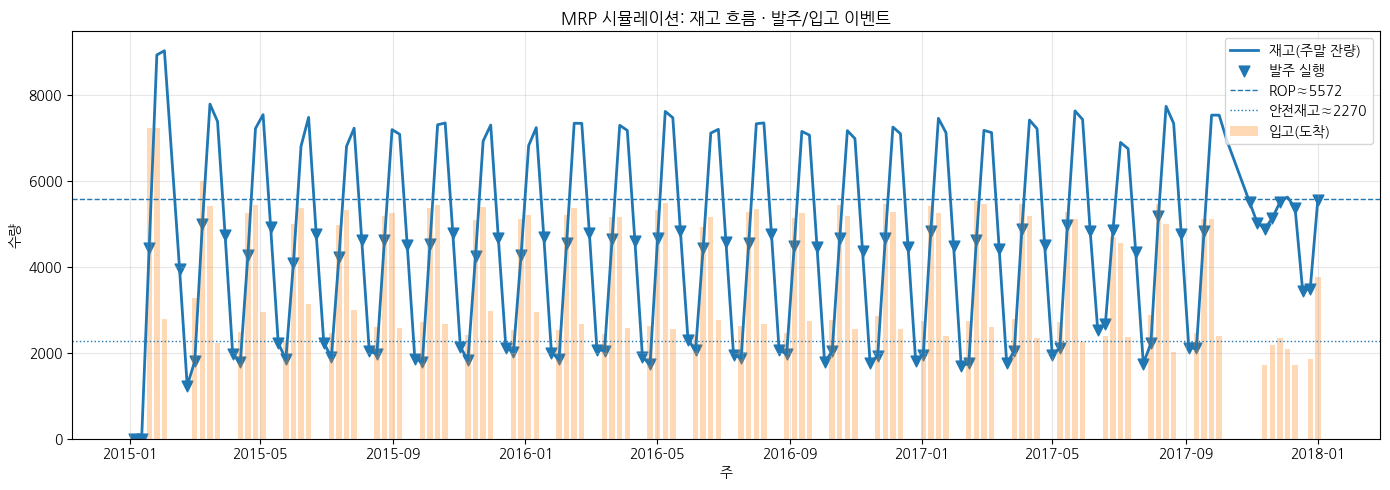

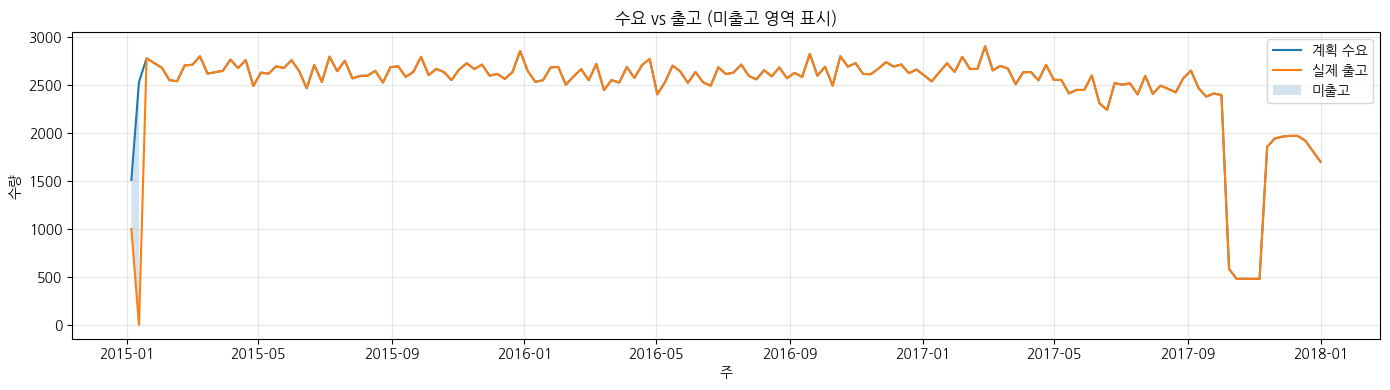

In [89]:
fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(sim["week"], sim["on_hand"], label="재고(주말 잔량)", linewidth=2)
ax1.scatter(sim.loc[sim["order_qty"]>0, "week"],
            sim.loc[sim["order_qty"]>0, "on_hand"],
            s=60, marker="v", label="발주 실행")
ax1.bar(sim["week"], sim["receipt"], alpha=0.3, label="입고(도착)", width=5)
ax1.axhline(ROP, linestyle="--", linewidth=1, label=f"ROP≈{ROP}")
ax1.axhline(safety_stock, linestyle=":", linewidth=1, label=f"안전재고≈{safety_stock}")
ax1.set_title("MRP 시뮬레이션: 재고 흐름 · 발주/입고 이벤트")
ax1.set_xlabel("주")
ax1.set_ylabel("수량")
ax1.grid(True, alpha=0.3)
ax1.legend(loc="upper right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(sim["week"], demand_plan["plan"], label="계획 수요")
plt.plot(sim["week"], sim["ship"], label="실제 출고")
plt.fill_between(sim["week"], sim["ship"], demand_plan["plan"], where=(sim["lost"]>0),
                 alpha=0.2, label="미출고")
plt.title("수요 vs 출고 (미출고 영역 표시)")
plt.xlabel("주")
plt.ylabel("수량")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

- 시뮬은 모양 = 톱니형 재고, 발주·입고 이벤트 잘 찍힘
- Fill Rate 99.23%면 공급 측면은 매우 안정적

다만 숫자를 풀어보면 안전재고·ROP 산출의 기준 평균수요가 낮게 잡힌 흔적이 있어 정책(파라미터) 재점검이 필요